# Sistem Prediksi Maintenance Asset

Dataset: 454 asset manufacturing dari database SIAPTEK (REAL DATA)

Target:
- Klasifikasi: Perlu diganti atau tidak (Binary Classification)
- Regresi: Estimasi berapa bulan lagi perlu diganti (Continuous Regression)

Algoritma: Random Forest (Ensemble Learning)

Expected lifespan: 120 bulan (10 tahun)
Target calculation: Realistic remaining life based on age, breakdowns, and usage intensity

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Load Dataset

In [86]:
df = pd.read_csv('training_data.csv')

print(f"Dataset: REAL DATA dari Web SIAPTEK")
print(f"Total: {len(df)} assets")
print(f"Features: {len(df.columns)} columns")

print(f"\nTarget distribution:")
target_dist = df['perlu_diganti'].value_counts()
print(f"  Tidak perlu (0): {target_dist[0]} ({target_dist[0]/len(df)*100:.1f}%)")
if 1 in target_dist.index:
    print(f"  Perlu diganti (1): {target_dist[1]} ({target_dist[1]/len(df)*100:.1f}%)")
else:
    print(f"  Perlu diganti (1): 0 (0.0%)")

print(f"\nAge range: {df['umur_aset_bulan'].min()}-{df['umur_aset_bulan'].max()} months")
print(f"Avg age: {df['umur_aset_bulan'].mean():.1f} months")

df.head()

Dataset: REAL DATA dari Web SIAPTEK
Total: 454 assets
Features: 18 columns

Target distribution:
  Tidak perlu (0): 410 (90.3%)
  Perlu diganti (1): 44 (9.7%)

Age range: 6-95 months
Avg age: 46.5 months


,itemd_id,branch_id,branch_name,kategori_id,kategori_name,umur_aset_bulan,frekuensi_issuing_6bulan,frekuensi_return_6bulan,avg_durasi_pemakaian_hari,total_hari_digunakan,jumlah_kerusakan,hari_sejak_kerusakan_terakhir,pernah_diperbaiki,posisi_saat_ini,lama_di_customer_hari,intensitas_penggunaan_score,perlu_diganti,estimasi_bulan_penggantian
0,2541,1,Siaptek-Jakarta,1,Heavy Equipment,95,8,8,6.25,841,7,13,1,warehouse,0,3.8,1,0
1,2542,1,Siaptek-Jakarta,2,Lifting Appliances,60,0,0,0.00,585,3,1421,1,warehouse,0,0.0,0,25
2,2544,1,Siaptek-Jakarta,3,Lifting Gears & Rigging,10,0,0,0.00,0,0,999,0,warehouse,0,0.0,0,97
3,2545,1,Siaptek-Jakarta,5,Fire Fighting & HSE,55,0,0,0.00,426,4,1160,1,warehouse,0,0.0,0,9
4,2546,1,Siaptek-Jakarta,2,Lifting Appliances,80,0,0,0.00,110,0,999,0,warehouse,0,0.0,0,34


## 2. Eksplorasi Data

In [87]:
df.info()
print("\n" + "="*60)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   itemd_id                       454 non-null    int64  
 1   branch_id                      454 non-null    int64  
 2   branch_name                    454 non-null    object 
 3   kategori_id                    454 non-null    int64  
 4   kategori_name                  454 non-null    object 
 5   umur_aset_bulan                454 non-null    int64  
 6   frekuensi_issuing_6bulan       454 non-null    int64  
 7   frekuensi_return_6bulan        454 non-null    int64  
 8   avg_durasi_pemakaian_hari      454 non-null    float64
 9   total_hari_digunakan           454 non-null    int64  
 10  jumlah_kerusakan               454 non-null    int64  
 11  hari_sejak_kerusakan_terakhir  454 non-null    int64  
 12  pernah_diperbaiki              454 non-null    int

,itemd_id,branch_id,kategori_id,umur_aset_bulan,frekuensi_issuing_6bulan,frekuensi_return_6bulan,avg_durasi_pemakaian_hari,total_hari_digunakan,jumlah_kerusakan,hari_sejak_kerusakan_terakhir,pernah_diperbaiki,lama_di_customer_hari,intensitas_penggunaan_score,perlu_diganti,estimasi_bulan_penggantian
count,454.000000,454.0,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.0,454.000000,454.000000,454.000000
mean,2791.790749,1.0,4.240088,46.477974,0.488987,0.365639,7.688502,390.398678,2.229075,979.286344,0.795154,0.0,0.306204,0.096916,46.735683
std,144.288458,0.0,2.285780,23.831143,1.064628,0.812844,24.126430,334.821869,1.651928,591.327811,0.404034,0.0,0.612202,0.296170,34.658673
min,2541.000000,1.0,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,2667.250000,1.0,2.250000,26.000000,0.000000,0.000000,0.000000,108.250000,1.000000,514.000000,1.000000,0.0,0.000000,0.000000,18.000000
50%,2789.500000,1.0,4.000000,46.000000,0.000000,0.000000,0.000000,323.500000,2.000000,999.000000,1.000000,0.0,0.000000,0.000000,43.500000
75%,2918.750000,1.0,6.000000,69.000000,0.000000,0.000000,0.000000,605.000000,3.750000,1421.750000,1.000000,0.0,0.000000,0.000000,73.000000
max,3040.000000,1.0,8.000000,95.000000,8.000000,8.000000,141.000000,1383.000000,7.000000,2386.000000,1.000000,0.0,3.800000,1.000000,129.000000


In [88]:
missing = df.isnull().sum()
if missing.sum() > 0:
    print("Missing values:")
    print(missing[missing > 0])
else:
    print("No missing values")

No missing values


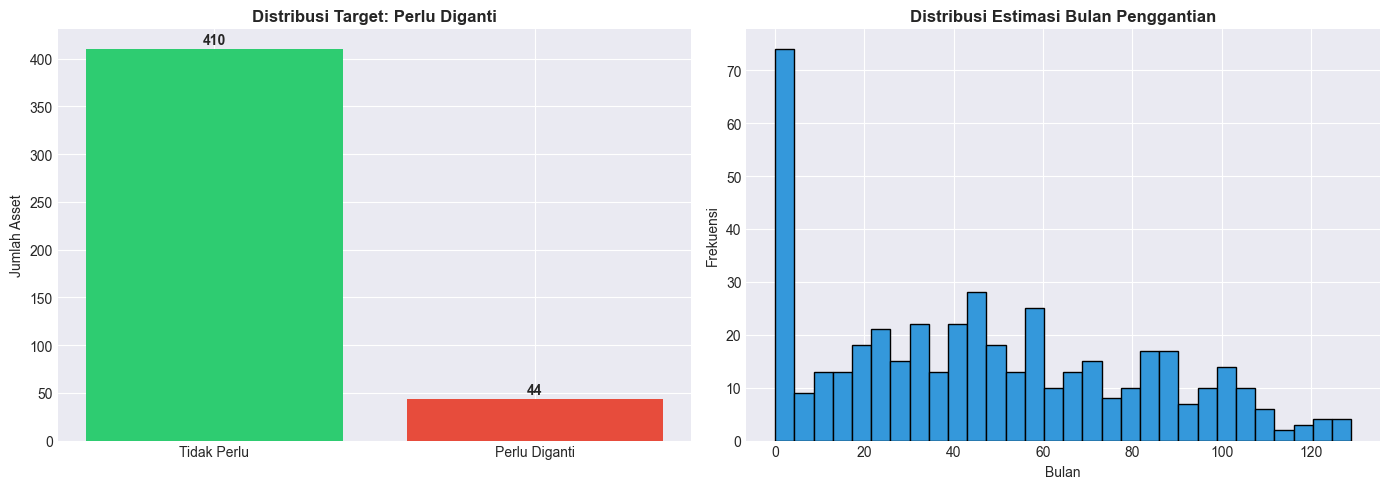

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

perlu_diganti_counts = df['perlu_diganti'].value_counts()
axes[0].bar(['Tidak Perlu', 'Perlu Diganti'], perlu_diganti_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribusi Target: Perlu Diganti', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Jumlah Asset')
for i, v in enumerate(perlu_diganti_counts.values):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

axes[1].hist(df['estimasi_bulan_penggantian'], bins=30, color='#3498db', edgecolor='black')
axes[1].set_title('Distribusi Estimasi Bulan Penggantian', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Bulan')
axes[1].set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()

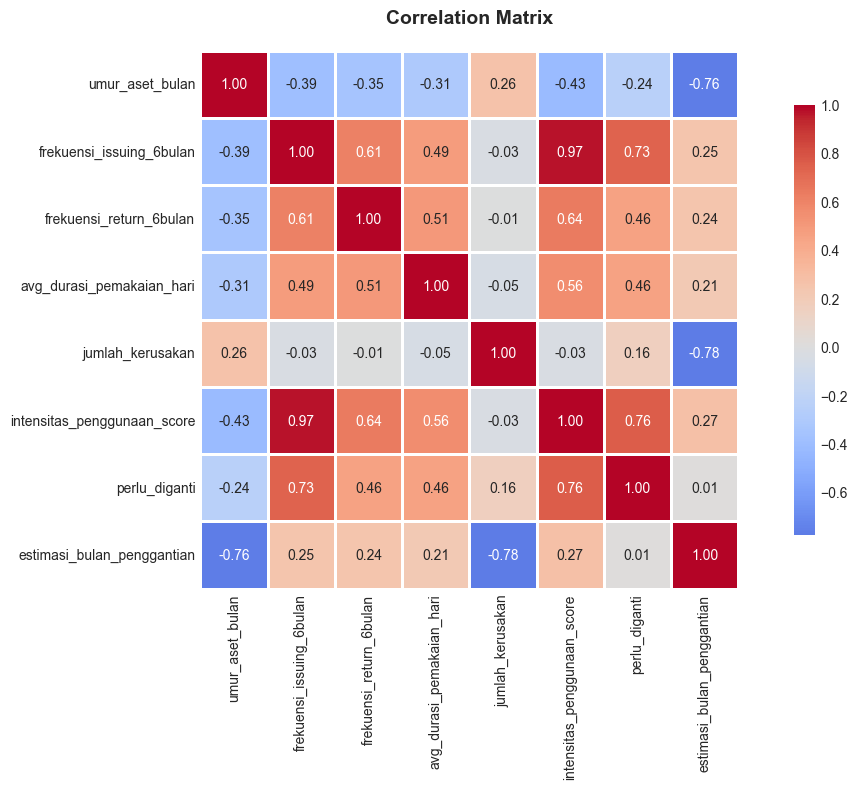

In [90]:
correlation = df[[
    'umur_aset_bulan', 'frekuensi_issuing_6bulan', 'frekuensi_return_6bulan',
    'avg_durasi_pemakaian_hari', 'jumlah_kerusakan', 'intensitas_penggunaan_score',
    'perlu_diganti', 'estimasi_bulan_penggantian'
]].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 3. Preprocessing

In [91]:
feature_cols = [
    'umur_aset_bulan',
    'kategori_id',
    'branch_id',
    'frekuensi_issuing_6bulan',
    'frekuensi_return_6bulan',
    'avg_durasi_pemakaian_hari',
    'total_hari_digunakan',
    'jumlah_kerusakan',
    'hari_sejak_kerusakan_terakhir',
    'pernah_diperbaiki',
    'lama_di_customer_hari',
    'intensitas_penggunaan_score'
]

X = df[feature_cols].copy()
y_class = df['perlu_diganti'].copy()
y_reg = df['estimasi_bulan_penggantian'].copy()

print(f"Features (X): {X.shape}")
print(f"Target Classification (y_class): {y_class.shape}")
print(f"Target Regression (y_reg): {y_reg.shape}")

Features (X): (454, 12)
Target Classification (y_class): (454,)
Target Regression (y_reg): (454,)


In [92]:
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42, stratify=y_class
)

print("Training set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_class_train: {y_class_train.shape}")
print(f"  y_reg_train: {y_reg_train.shape}")
print("\nTest set:")
print(f"  X_test: {X_test.shape}")
print(f"  y_class_test: {y_class_test.shape}")
print(f"  y_reg_test: {y_reg_test.shape}")

Training set:
  X_train: (363, 12)
  y_class_train: (363,)
  y_reg_train: (363,)

Test set:
  X_test: (91, 12)
  y_class_test: (91,)
  y_reg_test: (91,)


## 4. Model Training

Random Forest dengan 2 model terpisah:
- Classifier: Prediksi perlu diganti (Ya/Tidak)
- Regressor: Estimasi berapa bulan lagi

In [93]:
print("Training Classification Model...")
print(f"Class imbalance: 0={( y_class_train == 0).sum()}, 1={(y_class_train == 1).sum()}")

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_classifier.fit(X_train, y_class_train)
print("Classifier trained successfully")

Training Classification Model...
Class imbalance: 0=328, 1=35
Classifier trained successfully


In [94]:
print("Training Regression Model...")

rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_reg_train)
print("Regressor trained successfully")

Training Regression Model...
Regressor trained successfully
Regressor trained successfully


## 5. Evaluasi Model Klasifikasi

In [95]:
y_class_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_class_test, y_class_pred)
precision = precision_score(y_class_test, y_class_pred)
recall = recall_score(y_class_test, y_class_pred)
f1 = f1_score(y_class_test, y_class_pred)

print("="*60)
print("CLASSIFICATION METRICS")
print("="*60)
print(f"Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")
print("\n" + classification_report(y_class_test, y_class_pred, target_names=['Tidak Perlu', 'Perlu Diganti']))

CLASSIFICATION METRICS
Accuracy  : 0.9560 (95.60%)
Precision : 0.8571
Recall    : 0.6667
F1-Score  : 0.7500

               precision    recall  f1-score   support

  Tidak Perlu       0.96      0.99      0.98        82
Perlu Diganti       0.86      0.67      0.75         9

     accuracy                           0.96        91
    macro avg       0.91      0.83      0.86        91
 weighted avg       0.95      0.96      0.95        91



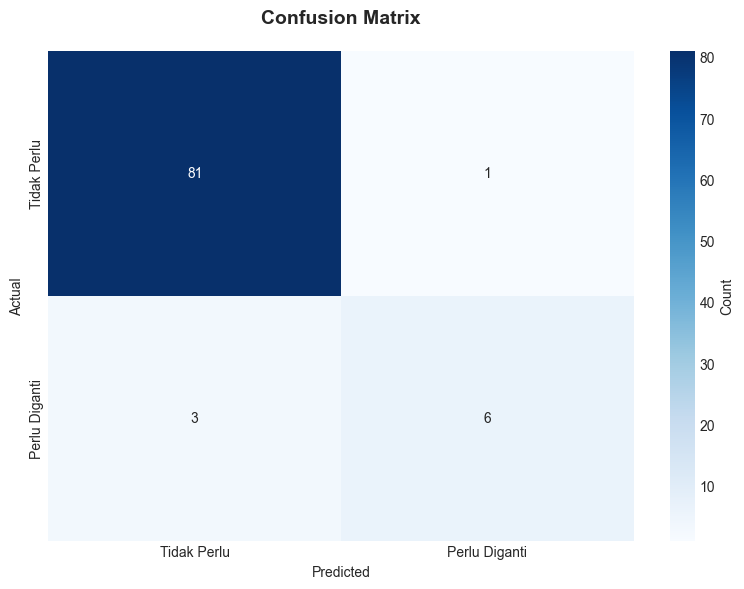

In [96]:
cm = confusion_matrix(y_class_test, y_class_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tidak Perlu', 'Perlu Diganti'],
            yticklabels=['Tidak Perlu', 'Perlu Diganti'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

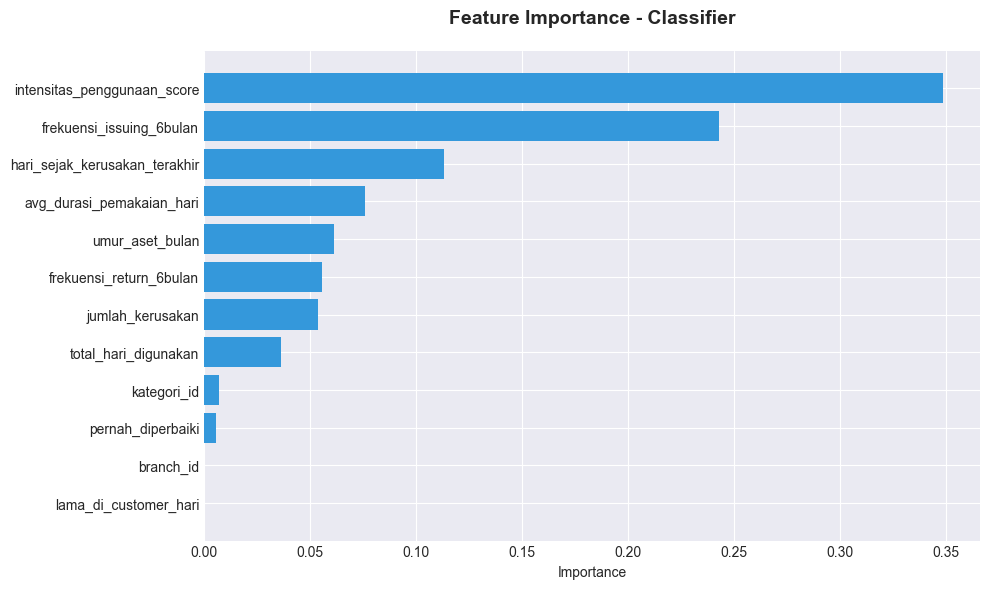


Top 5 Important Features:
                          feature  importance
11    intensitas_penggunaan_score    0.348652
3        frekuensi_issuing_6bulan    0.243110
8   hari_sejak_kerusakan_terakhir    0.113279
5       avg_durasi_pemakaian_hari    0.075988
0                 umur_aset_bulan    0.061290


In [97]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#3498db')
plt.xlabel('Importance')
plt.title('Feature Importance - Classifier', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Important Features:")
print(feature_importance.head())

## 6. Evaluasi Model Regresi

In [98]:
y_reg_pred = rf_regressor.predict(X_test)

mae = mean_absolute_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)

print("="*60)
print("REGRESSION METRICS")
print("="*60)
print(f"MAE  : {mae:.4f} bulan")
print(f"RMSE : {rmse:.4f} bulan")
print(f"R²   : {r2:.4f}")
print(f"\nInterpretasi:")
print(f"- Rata-rata error: ±{mae:.1f} bulan")
print(f"- Model explains {r2*100:.1f}% variance")

REGRESSION METRICS
MAE  : 7.9793 bulan
RMSE : 10.3188 bulan
R²   : 0.9117

Interpretasi:
- Rata-rata error: ±8.0 bulan
- Model explains 91.2% variance


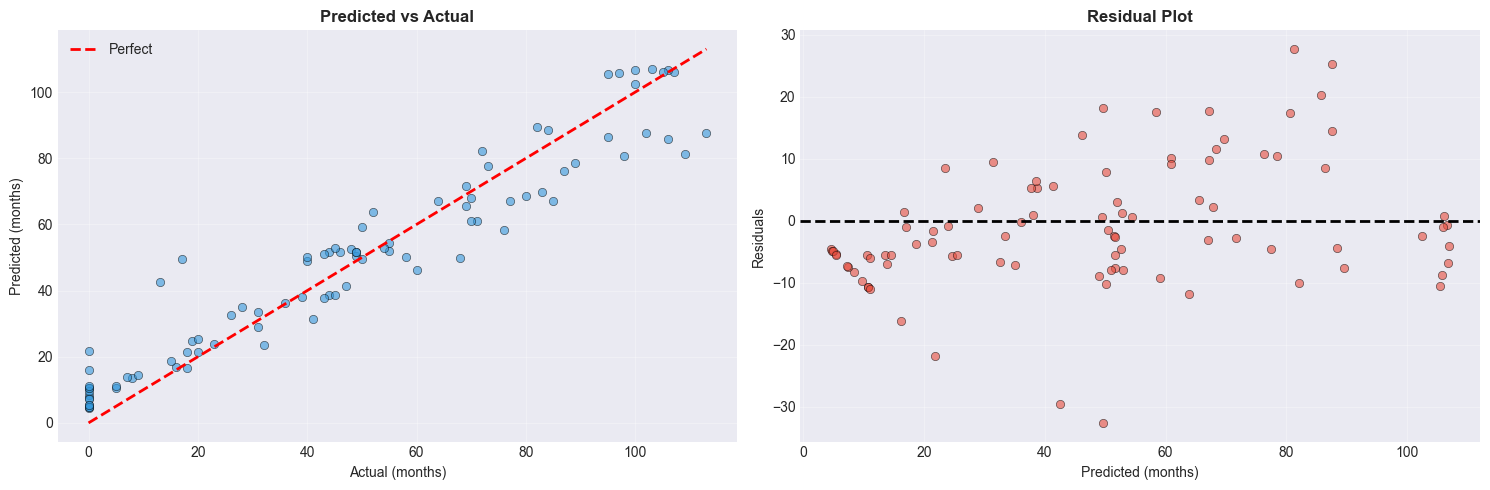

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_reg_test, y_reg_pred, alpha=0.6, color='#3498db', edgecolors='black', linewidth=0.5)
axes[0].plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 
             'r--', lw=2, label='Perfect')
axes[0].set_xlabel('Actual (months)')
axes[0].set_ylabel('Predicted (months)')
axes[0].set_title('Predicted vs Actual', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_reg_test - y_reg_pred
axes[1].scatter(y_reg_pred, residuals, alpha=0.6, color='#e74c3c', edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted (months)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

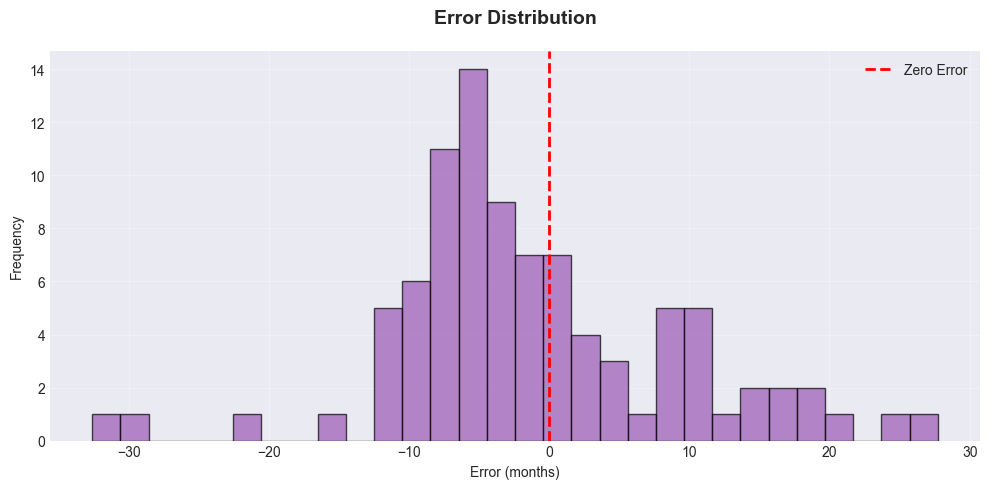

Mean error: -0.9141 months
Std error: 10.3352 months


In [100]:
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel('Error (months)')
plt.ylabel('Frequency')
plt.title('Error Distribution', fontsize=14, fontweight='bold', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Mean error: {residuals.mean():.4f} months")
print(f"Std error: {residuals.std():.4f} months")

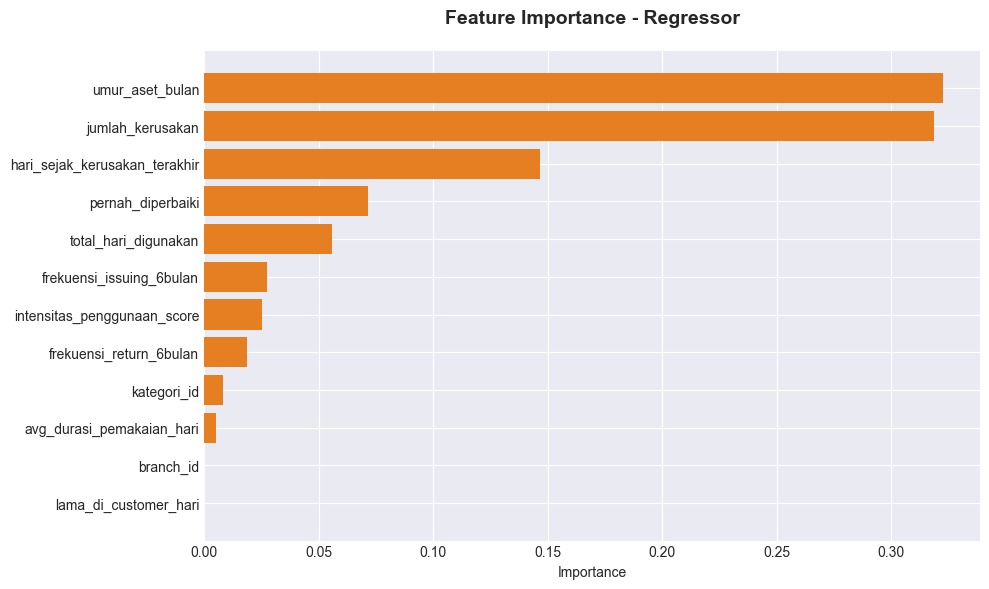


Top 5 Important Features:
                         feature  importance
0                umur_aset_bulan    0.322605
7               jumlah_kerusakan    0.318524
8  hari_sejak_kerusakan_terakhir    0.146729
9              pernah_diperbaiki    0.071521
6           total_hari_digunakan    0.055767


In [101]:
feature_importance_reg = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_reg['feature'], feature_importance_reg['importance'], color='#e67e22')
plt.xlabel('Importance')
plt.title('Feature Importance - Regressor', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Important Features:")
print(feature_importance_reg.head())

## 7. Cross Validation

In [102]:
print("Cross Validation - Classifier")
cv_scores_class = cross_val_score(rf_classifier, X_train, y_class_train, cv=5, scoring='accuracy')
print(f"Accuracy per fold: {cv_scores_class}")
print(f"Mean: {cv_scores_class.mean():.4f} (+/- {cv_scores_class.std():.4f})")

print("\nCross Validation - Regressor")
cv_scores_reg = cross_val_score(rf_regressor, X_train, y_reg_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_reg = -cv_scores_reg
print(f"MAE per fold: {cv_scores_reg}")
print(f"Mean: {cv_scores_reg.mean():.4f} (+/- {cv_scores_reg.std():.4f})")

Cross Validation - Classifier
Accuracy per fold: [0.98630137 0.98630137 0.97260274 0.98611111 0.97222222]
Mean: 0.9807 (+/- 0.0068)

Cross Validation - Regressor
Accuracy per fold: [0.98630137 0.98630137 0.97260274 0.98611111 0.97222222]
Mean: 0.9807 (+/- 0.0068)

Cross Validation - Regressor
MAE per fold: [6.66008699 9.0451715  8.17601233 7.4536907  7.69093312]
Mean: 7.8052 (+/- 0.7903)
MAE per fold: [6.66008699 9.0451715  8.17601233 7.4536907  7.69093312]
Mean: 7.8052 (+/- 0.7903)


## 7.1. Overfitting Check

Membandingkan performa model di training set vs test set untuk deteksi overfitting

In [103]:
print("="*60)
print("OVERFITTING CHECK - CLASSIFICATION")
print("="*60)

# Training set performance
y_class_train_pred = rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_class_train, y_class_train_pred)
train_precision = precision_score(y_class_train, y_class_train_pred)
train_recall = recall_score(y_class_train, y_class_train_pred)
train_f1 = f1_score(y_class_train, y_class_train_pred)

# Test set performance (already calculated)
test_accuracy = accuracy
test_precision = precision
test_recall = recall
test_f1 = f1

print(f"\nTRAINING SET:")
print(f"  Accuracy  : {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Precision : {train_precision:.4f}")
print(f"  Recall    : {train_recall:.4f}")
print(f"  F1-Score  : {train_f1:.4f}")

print(f"\nTEST SET:")
print(f"  Accuracy  : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Precision : {test_precision:.4f}")
print(f"  Recall    : {test_recall:.4f}")
print(f"  F1-Score  : {test_f1:.4f}")

print(f"\nGAP (Train - Test):")
gap_accuracy = train_accuracy - test_accuracy
gap_precision = train_precision - test_precision
gap_recall = train_recall - test_recall
gap_f1 = train_f1 - test_f1

print(f"  Accuracy  : {gap_accuracy:+.4f} ({gap_accuracy*100:+.2f}%)")
print(f"  Precision : {gap_precision:+.4f}")
print(f"  Recall    : {gap_recall:+.4f}")
print(f"  F1-Score  : {gap_f1:+.4f}")

if gap_accuracy > 0.1 or gap_f1 > 0.1:
    print("\n⚠️  WARNING: Significant overfitting detected (gap > 10%)")
elif gap_accuracy > 0.05 or gap_f1 > 0.05:
    print("\n⚡ MODERATE: Some overfitting (gap 5-10%)")
else:
    print("\n✅ GOOD: No significant overfitting (gap < 5%)")

OVERFITTING CHECK - CLASSIFICATION

TRAINING SET:
  Accuracy  : 0.9890 (98.90%)
  Precision : 0.9697
  Recall    : 0.9143
  F1-Score  : 0.9412

TEST SET:
  Accuracy  : 0.9560 (95.60%)
  Precision : 0.8571
  Recall    : 0.6667
  F1-Score  : 0.7500

GAP (Train - Test):
  Accuracy  : +0.0329 (+3.29%)
  Precision : +0.1126
  Recall    : +0.2476
  F1-Score  : +0.1912

⚠️  WARNING: Significant overfitting detected (gap > 10%)


In [104]:
print("="*60)
print("OVERFITTING CHECK - REGRESSION")
print("="*60)

# Training set performance
y_reg_train_pred = rf_regressor.predict(X_train)
train_mae = mean_absolute_error(y_reg_train, y_reg_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_reg_train, y_reg_train_pred))
train_r2 = r2_score(y_reg_train, y_reg_train_pred)

# Test set performance (already calculated)
test_mae = mae
test_rmse = rmse
test_r2 = r2

print(f"\nTRAINING SET:")
print(f"  MAE  : {train_mae:.4f} bulan")
print(f"  RMSE : {train_rmse:.4f} bulan")
print(f"  R²   : {train_r2:.4f}")

print(f"\nTEST SET:")
print(f"  MAE  : {test_mae:.4f} bulan")
print(f"  RMSE : {test_rmse:.4f} bulan")
print(f"  R²   : {test_r2:.4f}")

print(f"\nGAP:")
gap_mae = test_mae - train_mae
gap_rmse = test_rmse - train_rmse
gap_r2 = train_r2 - test_r2

print(f"  MAE  : {gap_mae:+.4f} bulan ({gap_mae/train_mae*100:+.1f}%)")
print(f"  RMSE : {gap_rmse:+.4f} bulan ({gap_rmse/train_rmse*100:+.1f}%)")
print(f"  R²   : {gap_r2:+.4f} ({gap_r2*100:+.1f}%)")

if gap_r2 > 0.1:
    print("\n⚠️  WARNING: Significant overfitting (R² gap > 10%)")
elif gap_r2 > 0.05:
    print("\n⚡ MODERATE: Some overfitting (R² gap 5-10%)")
else:
    print("\n✅ GOOD: No significant overfitting (R² gap < 5%)")

OVERFITTING CHECK - REGRESSION

TRAINING SET:
  MAE  : 6.0950 bulan
  RMSE : 7.7664 bulan
  R²   : 0.9496

TEST SET:
  MAE  : 7.9793 bulan
  RMSE : 10.3188 bulan
  R²   : 0.9117

GAP:
  MAE  : +1.8844 bulan (+30.9%)
  RMSE : +2.5524 bulan (+32.9%)
  R²   : +0.0379 (+3.8%)

✅ GOOD: No significant overfitting (R² gap < 5%)


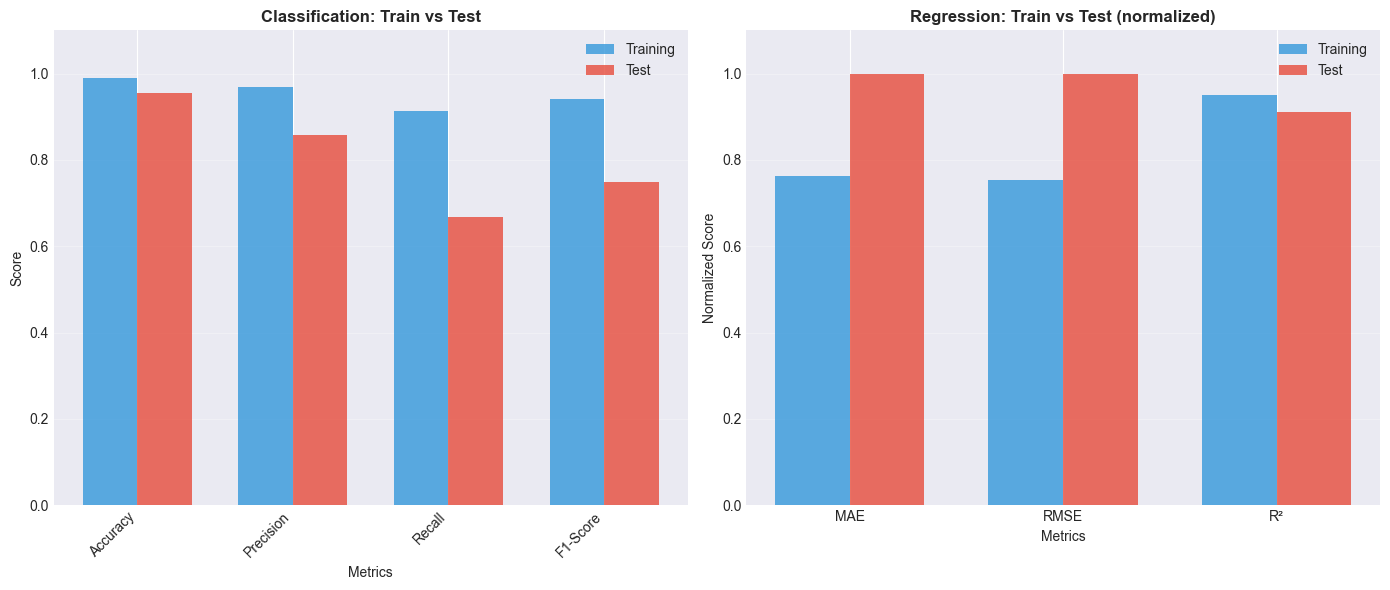


📊 Lower bars in test set indicate overfitting
📊 Similar height = good generalization


In [105]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Classification comparison
metrics_class = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics_class))
width = 0.35

axes[0].bar(x - width/2, train_scores, width, label='Training', color='#3498db', alpha=0.8)
axes[0].bar(x + width/2, test_scores, width, label='Test', color='#e74c3c', alpha=0.8)
axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Classification: Train vs Test', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_class, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(True, alpha=0.3, axis='y')

# Regression comparison
metrics_reg = ['MAE', 'RMSE', 'R²']
train_scores_reg = [train_mae, train_rmse, train_r2]
test_scores_reg = [test_mae, test_rmse, test_r2]

# Normalize MAE and RMSE to 0-1 scale for visualization
max_mae = max(train_mae, test_mae)
max_rmse = max(train_rmse, test_rmse)
train_scores_norm = [train_mae/max_mae, train_rmse/max_rmse, train_r2]
test_scores_norm = [test_mae/max_mae, test_rmse/max_rmse, test_r2]

x2 = np.arange(len(metrics_reg))
axes[1].bar(x2 - width/2, train_scores_norm, width, label='Training', color='#3498db', alpha=0.8)
axes[1].bar(x2 + width/2, test_scores_norm, width, label='Test', color='#e74c3c', alpha=0.8)
axes[1].set_xlabel('Metrics')
axes[1].set_ylabel('Normalized Score')
axes[1].set_title('Regression: Train vs Test (normalized)', fontsize=12, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(metrics_reg)
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Lower bars in test set indicate overfitting")
print("📊 Similar height = good generalization")

## 8. Save Model

In [106]:
# import os
# import pickle

# model_dir = 'models'
# os.makedirs(model_dir, exist_ok=True)

# model_version = datetime.now().strftime('%Y%m%d_%H%M%S')

# classifier_path = f'{model_dir}/rf_classifier_{model_version}.pkl'
# regressor_path = f'{model_dir}/rf_regressor_{model_version}.pkl'

# with open(classifier_path, 'wb') as f:
#     pickle.dump(rf_classifier, f)
# print(f"Classifier saved: {classifier_path}")

# with open(regressor_path, 'wb') as f:
#     pickle.dump(rf_regressor, f)
# print(f"Regressor saved: {regressor_path}")

In [107]:
metrics = {
    'model_version': model_version,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'classifier': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'cv_mean': float(cv_scores_class.mean()),
        'cv_std': float(cv_scores_class.std())
    },
    'regressor': {
        'mae': float(mae),
        'rmse': float(rmse),
        'r2_score': float(r2),
        'cv_mean_mae': float(cv_scores_reg.mean()),
        'cv_std_mae': float(cv_scores_reg.std())
    },
    'dataset': {
        'total_samples': len(df),
        'training_samples': len(X_train),
        'testing_samples': len(X_test),
        'features': feature_cols
    }
}

# metrics_path = f'{model_dir}/metrics_{model_version}.json'
# with open(metrics_path, 'w') as f:
#     json.dump(metrics, f, indent=2)

# print(f"Metrics saved: {metrics_path}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Classification Accuracy: {accuracy:.1%}")
print(f"Regression MAE: {mae:.2f} months")
print(f"Regression R²: {r2:.3f}")


SUMMARY
Classification Accuracy: 95.6%
Regression MAE: 7.98 months
Regression R²: 0.912


## 9. Test Predictions

In [108]:
sample_indices = np.random.choice(X_test.index, 5, replace=False)
sample_data = X_test.loc[sample_indices]

pred_class = rf_classifier.predict(sample_data)
pred_reg = rf_regressor.predict(sample_data)

results = pd.DataFrame({
    'Age': sample_data['umur_aset_bulan'].values,
    'Breakdown': sample_data['jumlah_kerusakan'].values,
    'Intensity': sample_data['intensitas_penggunaan_score'].values,
    'Pred_Status': ['Perlu' if x == 1 else 'Tidak' for x in pred_class],
    'Pred_Months': [f'{int(x)}' for x in pred_reg],
    'Actual_Status': ['Perlu' if x == 1 else 'Tidak' for x in y_class_test.loc[sample_indices].values],
    'Actual_Months': [f'{int(x)}' for x in y_reg_test.loc[sample_indices].values]
})

print("Sample Predictions:")
print(results.to_string(index=False))

Sample Predictions:
 Age  Breakdown  Intensity Pred_Status Pred_Months Actual_Status Actual_Months
  57          4        0.0       Tidak          13         Tidak             7
  32          1        1.0       Tidak          71         Tidak            69
  34          3        1.4       Perlu          48         Perlu            40
  24          2        2.2       Perlu          67         Perlu            64
  37          2        2.2       Tidak          59         Perlu            50
